# Facebook Metrics Modeling

So far we have found that most of the attributes in our facebook metrics dataset are positively correlated with each other. This shows us that we should perform some Dimensionality Reduction techniques to get a better understanding of some of the core features/attributes that affect the total interactions of a facebook post. 

## Goal

The goal of this project is to build a model that captures and accurately predicts `total_interactions` using a smaller set of features better than a model that uses all the features avaiable to us. By the end of this project we hope to get a better understanding of what features have a stronger relationship with our target variable. 

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('../data/facebook_clean.csv')

In [3]:
df.head()

,total_likes,type,category,post_month,post_weekday,post_hour,paid,lifetime_reach,lifetime_impressions,lifetime_engaged_users,lifetime_consumers,lifetime_consumptions,impressions_by_likers,reach_by_likers,likers_who_engaged,total_interactions
0,139441,Photo,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,100
1,139441,Status,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,164
2,139441,Photo,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,80
3,139441,Photo,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,1777
4,139441,Photo,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,393


In [4]:
df.shape

(495, 16)

## Data Preparation

Before we begin building our model we must prepare our data for the purpose of machine learning model building. This means creating dummy variables for categorical columns like `type`, `category`, `post_month`, `post_weekday`, and `post_hour`. Through our exploratory data analysis we also noticed that our data is prone to outliers. For this reason we will also standardize our data in order to reduce the impace of outliers. 

In [5]:
#get our categorical columns
dummy_cols = ['type', 'category', 'post_month', 'post_weekday', 'post_hour']

In [6]:
#create a dataframe with all our dummy columns
dummy_df = df[dummy_cols]
dummy_df = pd.get_dummies(dummy_df, columns=dummy_cols, dtype='int')
dummy_df.head()

,type_Link,type_Photo,type_Status,type_Video,category_1,category_2,category_3,post_month_1,post_month_2,post_month_3,...,post_hour_13,post_hour_14,post_hour_15,post_hour_16,post_hour_17,post_hour_18,post_hour_19,post_hour_20,post_hour_22,post_hour_23
0,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
#get a dataframe of all our columns that need to be standardized
standard_df = df.drop(dummy_cols + ['paid', 'total_interactions'], axis=1)
#save the names for our columns
standard_cols = standard_df.columns

In [8]:
#standardize our numerical columns and make it into a dataframe
standard_df = StandardScaler().fit_transform(standard_df)
standard_df = pd.DataFrame(standard_df, columns=standard_cols)
standard_df.head()

,total_likes,lifetime_reach,lifetime_impressions,lifetime_engaged_users,lifetime_consumers,lifetime_consumptions,impressions_by_likers,reach_by_likers,likers_who_engaged
0,1.00496,-0.494610,-0.321365,-0.758912,-0.786117,-0.631681,-0.230587,-0.650161,-0.806770
1,1.00496,-0.156509,-0.140141,0.537308,0.629708,0.123691,-0.086752,-0.068815,0.804700
2,1.00496,-0.509479,-0.330682,-0.759926,-0.781594,-0.634174,-0.235019,-0.667971,-0.785588
3,1.00496,1.583469,0.754351,1.301459,-0.016008,-0.153029,0.735016,3.302788,1.257671
4,1.00496,-0.297575,-0.211030,-0.259275,-0.445731,-0.421772,-0.178098,-0.447366,-0.355428


In [9]:
standard_df.describe()

,total_likes,lifetime_reach,lifetime_impressions,lifetime_engaged_users,lifetime_consumers,lifetime_consumptions,impressions_by_likers,reach_by_likers,likers_who_engaged
count,495.000000,4.950000e+02,4.950000e+02,4.950000e+02,495.000000,4.950000e+02,4.950000e+02,4.950000e+02,4.950000e+02
mean,0.000000,-1.435440e-17,-1.435440e-17,-5.741759e-17,0.000000,-4.306320e-17,-2.870880e-17,-5.741759e-17,8.253779e-17
std,1.001012,1.001012e+00,1.001012e+00,1.001012e+00,1.001012,1.001012e+00,1.001012e+00,1.001012e+00,1.001012e+00
min,-2.582451,-6.048824e-01,-3.800299e-01,-9.301878e-01,-0.899202,-7.064703e-01,-2.724275e-01,-8.326771e-01,-9.860034e-01
25%,-0.670227,-4.692125e-01,-3.121910e-01,-5.349369e-01,-0.530545,-4.554276e-01,-2.139988e-01,-5.756730e-01,-5.159235e-01
50%,0.397020,-3.832839e-01,-2.695516e-01,-3.008268e-01,-0.281758,-2.816671e-01,-1.771987e-01,-4.112268e-01,-3.228404e-01
75%,0.816666,-3.421798e-02,-9.542577e-02,1.369896e-01,0.186414,2.646484e-02,-2.954809e-02,1.789597e-01,7.228745e-02
max,1.004960,7.301167e+00,1.401967e+01,1.066688e+01,11.900899,9.150759e+00,1.817791e+01,5.825770e+00,6.129556e+00


In [10]:
#combine all our data back together
df = pd.concat([standard_df, dummy_df, df[['paid', 'total_interactions']]], axis=1)
df.head()

,total_likes,lifetime_reach,lifetime_impressions,lifetime_engaged_users,lifetime_consumers,lifetime_consumptions,impressions_by_likers,reach_by_likers,likers_who_engaged,type_Link,...,post_hour_15,post_hour_16,post_hour_17,post_hour_18,post_hour_19,post_hour_20,post_hour_22,post_hour_23,paid,total_interactions
0,1.00496,-0.494610,-0.321365,-0.758912,-0.786117,-0.631681,-0.230587,-0.650161,-0.806770,0,...,0,0,0,0,0,0,0,0,0.0,100
1,1.00496,-0.156509,-0.140141,0.537308,0.629708,0.123691,-0.086752,-0.068815,0.804700,0,...,0,0,0,0,0,0,0,0,0.0,164
2,1.00496,-0.509479,-0.330682,-0.759926,-0.781594,-0.634174,-0.235019,-0.667971,-0.785588,0,...,0,0,0,0,0,0,0,0,0.0,80
3,1.00496,1.583469,0.754351,1.301459,-0.016008,-0.153029,0.735016,3.302788,1.257671,0,...,0,0,0,0,0,0,0,0,1.0,1777
4,1.00496,-0.297575,-0.211030,-0.259275,-0.445731,-0.421772,-0.178098,-0.447366,-0.355428,0,...,0,0,0,0,0,0,0,0,0.0,393


In [11]:
df.shape

(495, 59)

In [12]:
df.columns

Index(['total_likes', 'lifetime_reach', 'lifetime_impressions',
       'lifetime_engaged_users', 'lifetime_consumers', 'lifetime_consumptions',
       'impressions_by_likers', 'reach_by_likers', 'likers_who_engaged',
       'type_Link', 'type_Photo', 'type_Status', 'type_Video', 'category_1',
       'category_2', 'category_3', 'post_month_1', 'post_month_2',
       'post_month_3', 'post_month_4', 'post_month_5', 'post_month_6',
       'post_month_7', 'post_month_8', 'post_month_9', 'post_month_10',
       'post_month_11', 'post_month_12', 'post_weekday_1', 'post_weekday_2',
       'post_weekday_3', 'post_weekday_4', 'post_weekday_5', 'post_weekday_6',
       'post_weekday_7', 'post_hour_1', 'post_hour_2', 'post_hour_3',
       'post_hour_4', 'post_hour_5', 'post_hour_6', 'post_hour_7',
       'post_hour_8', 'post_hour_9', 'post_hour_10', 'post_hour_11',
       'post_hour_12', 'post_hour_13', 'post_hour_14', 'post_hour_15',
       'post_hour_16', 'post_hour_17', 'post_hour_18', 'post_ho

Next we will split our data into training, testing and validation sets. We have 495 rows to work with so we will aim at having a split of 60-20-20 percent for our corresponding training, testing and validation sets. 

In [13]:
#separate our features and target variable
X = df.drop('total_interactions', axis=1)
y = df['total_interactions']

In [14]:
#create our 60-20-20 split of our data
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=8)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=8)

In [15]:
#assert that our splits follow 60-20-20
print('Training set percent: ', X_train.shape[0] / df.shape[0])
print('Testing set percent: ', X_test.shape[0] / df.shape[0])
print('Validation set percent: ', X_val.shape[0] / df.shape[0])

Training set percent:  0.6
Testing set percent:  0.2
Validation set percent:  0.2


In [16]:
#dictionary that will be used to store our testing results
results = {}

## Establishing A Baseline

Now that we have our dummy variables as well as our training, testing and validation sets we are ready to begin building our regression models.

Since the purpose of project is to evaluate the important attributes using a linear regression model we must first create a baseline. The purpose of our baseline would be to compare how our future models with less attributes compare to a model with all the attributes present. 

The baseline model for this project will be a simple Ordinary Least Square Linear Regression model from `sklearn` using all the available features. We will evaluate all our models using Mean Absolute Error (MAE).

In [17]:
#used to store test results
results['baseline_reg'] = {}

#creating our baseline Linear Regression Model
baseline_reg = linear_model.LinearRegression()
baseline_reg.fit(X_train, y_train)

LinearRegression()

In [18]:
#evaluating our baseline regression model on training data
results['baseline_reg']['train_mae'] = mean_absolute_error(y_train, baseline_reg.predict(X_train))

In [19]:
#evaluating our baseline regression model on test data
results['baseline_reg']['test_mae'] = mean_absolute_error(y_test, baseline_reg.predict(X_test))

In [20]:
#see our results
results['baseline_reg']

{'train_mae': 35.21303458845312, 'test_mae': 32.74318852260635}

As we can see from our results above we have established a pretty good baseline. Our Ordinary Least Squares Linear Regression model using all the features has produced a training MAE of about 35.2 and a test set MAE of about 32.7, which is a really good starting point.

## PCA Attempt

For our next steps we will begin incorporating dimensionality reduction techniques along with other regression models to see if we can decrease our mean absolute error using simplified versions of our data. 

In [21]:
var_ratio = []
#principal component analysis on features
for num in np.arange(X.shape[1]):
    pca = PCA(n_components=num)
    pca.fit(X_train)
    var_ratio.append(np.sum(pca.explained_variance_ratio_))

Text(0.5, 1.0, 'n_components vs. Explained Variance Ratio')

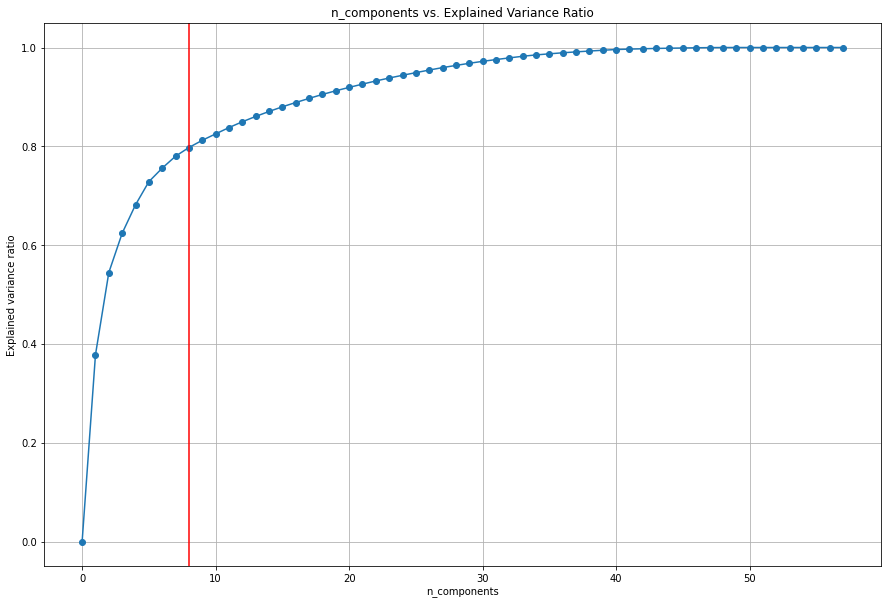

In [22]:
#plot the findings of our PCA
plt.figure(figsize=(15, 10))
plt.grid()
plt.plot(np.arange(X.shape[1]), var_ratio, marker='o')
plt.axvline(x=8, color='red')
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')

Performing our principal component analysis we find that the point of dimishing returns seems to be around 8 components. The graph above shows us that 8 features account for 80% of explained variance in our dataset. The explained variance slightly increases as we move from 8 components to the full 58 components. 

Lets create another Linear Regression model using only our 8 principal components to see how it compares to our baseline. 

In [23]:
#build a pca using 8 components
optimal_pca = PCA(n_components=8)

In [24]:
#build our pca training and testing sets
X_train_pca = optimal_pca.fit_transform(X_train)
X_test_pca = optimal_pca.transform(X_test)

In [25]:
#used to store test results
results['pca_reg'] = {}

#creating our pca regression model
pca_reg = linear_model.LinearRegression()
pca_reg.fit(X_train_pca, y_train)

LinearRegression()

In [26]:
#evaluating our pca model on the training data
results['pca_reg']['train_mae'] = mean_absolute_error(y_train, pca_reg.predict(X_train_pca))

In [27]:
#evaluating our pca model on the test data
results['pca_reg']['test_mae'] = mean_absolute_error(y_test, pca_reg.predict(X_test_pca))

In [28]:
#see our pca results
results['pca_reg']

{'train_mae': 117.25145757318911, 'test_mae': 75.90347915888034}

As we can see from our mean absolute error results for our pca regression model, we did worse than our baseline model. Although we chose some of the variables that accounted for most of the variance in our dataset our linear regression model did not perform. This can be due to the fact that principal component analysis eliminates multicollinearity between features. This means that when we perform PCA we are combining our highly correlated variables into a set of uncorrelated variables. It is important to note that this is strictly for our features, PCA does not evaluate the correlation between features and our target variable it is strictly dealing with collinearity.

We can conclude that our first attempt at improving our mean absolute error using our first dimensionality reduction technique of principal component analysis was a failure. 

## Lasso Regression & Feature Selection

In this final attempt of improving our mean absolute error score we turn to Lasso Regression. LASSO stands for Least Absolute Shrinkage and Selection Operator and is a regularization technique that adds a penalty term which forces some coefficients to be exactly zero. This means that through our regression model we can perform some feature selection by selecting those features whose coefficients are not zero.

In [29]:
#building our lasso regression model
lasso_reg = linear_model.LassoCV(cv=5).fit(X_train, y_train)

In [30]:
#view our results
results['lasso_reg'] = {}

#evaluating our lasso model on the training data
results['lasso_reg']['train_mae'] = mean_absolute_error(y_train, lasso_reg.predict(X_train))
#evaluating our lasso model on the test data
results['lasso_reg']['test_mae'] = mean_absolute_error(y_test, lasso_reg.predict(X_test))

In [31]:
results['lasso_reg']

{'train_mae': 37.07270201521414, 'test_mae': 29.961926243876075}

With our Lasso regression model we did only slightly worse on our training MAE but improved on our test MAE. We also did this using a smaller amount of features than with our baseline regression model. Lets that a look at some of the features our model chose. 

In [32]:
#how many features have nonzero coefficients
np.count_nonzero(lasso_reg.coef_)

20

In [33]:
#find the column names of our nonzero columns and their coefficients
values = []
for idx,  coeff in enumerate(lasso_reg.coef_):
    if coeff != 0:
        values.append([X_train.columns[idx], coeff])

In [34]:
pd.DataFrame(values, columns=['column_name', 'coefficient']).sort_values(by='coefficient')

,column_name,coefficient
2,lifetime_consumers,-1016.892696
7,type_Status,-41.594731
8,category_1,-33.140026
13,post_month_12,-14.418942
11,post_month_6,-8.053808
15,post_weekday_7,-6.017957
17,post_hour_10,-5.340368
0,total_likes,-4.764505
19,paid,1.743135
10,post_month_5,2.837544


## Conclusion

Using an ordinary least squares regression model as our baseline we compared two different approaches of dimensionality reduction. 

The first approach of Principal Component Analysis proved to be a failure. Initially PCA seemed to be a great idea due to the fact that from our EDA analysis we observed how our features were mostly correlated with each other. The initial idea was to use PCA to remove the multicollinearity while still capturing most of the variance present in our dataset. 

The second approach was using Lasso regression as a form of feature selection. This is because since Lasso regression reduces the coefficients of some features down to zero we can essentially view this as a form of selecting only those features that have a significant impact on the target variable. Through this we found that the features `lifetime_engaged_users` and `lifetime_consumers` had the largest coefficients while the feature `paid` was closest to zero.  

In [35]:
#results into a dataframe
pd.DataFrame(results)

,baseline_reg,pca_reg,lasso_reg
train_mae,35.213035,117.251458,37.072702
test_mae,32.743189,75.903479,29.961926


In [36]:
#best model on validation data
validate_mae = mean_absolute_error(y_val, lasso_reg.predict(X_val))

In [37]:
print('The Mean Absolute Error of our best model on our validation data is:', validate_mae)

The Mean Absolute Error of our best model on our validation data is: 53.12462904881559


## For The Future 

As we can see above our best model was the Lasso regression model. Although this model performed well on our training and testing sets, it did not perform as expected on our validation data. There is a large amount of variation between our training, testing and validation MAE for our Lasso model. This shows us that we are not fully capturing the trends within our data. In the future it could be even more useful to build a better model that fully captures our data, this model should have MAE outputs with a higher precision meaning our MAE have lower variance than what we have seen in this project. 